<a href="https://colab.research.google.com/github/asriva13/PINN/blob/main/4D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs
! apt-get update
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super
! pip install dmsh
! pip install optimesh

In [ ]:
#@title Imports
%matplotlib inline
import jax.numpy as np
import numpy
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import jacfwd, jacrev
from jax.numpy import linalg
from jax.example_libraries import optimizers


# This import registers the 3D projection, but is otherwise unused.
#from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import LogNorm
import scipy as sc
from mpl_toolkits.axes_grid1 import ImageGrid
import string
import dmsh
import meshio
import optimesh
import meshplex
from numpy import loadtxt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.tri as tri

#from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
#%matplotlib inline

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

key = random.PRNGKey(0)

In [ ]:
#@title Functions
##################
#Definitions relevant to NN architecture.
########################
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

def ReLU2(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, np.sign(x)*x**2))

def ReLU3(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return (np.maximum(0, x**3))

def sigmoid(x):
    return 1./(1. + np.exp(-x))

def tanh(x):
    return 2.*sigmoid(2*x)-1.

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def relu2_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU2(np.dot(params[0], x) + params[1])

def relu3_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU3(np.dot(params[0], x) + params[1])

def sigmoid_layer(params, x):
    """ Simple ReLu layer for single sample """
    return sigmoid(np.dot(params[0], x) + params[1])

def tanh_layer(params, x):
    """ Simple ReLu layer for single sample """
    return tanh(np.dot(params[0], x) + params[1])

############################
############################
#Basic geometry; o=0 for cc and 1 for c

def polygon(points,o=0):
  l = len(points[:,0])
  segments = numpy.zeros((l,4))
  for i in range(l-1):
    segments[i,:2]=points[i,:]
    segments[i,2:4]=points[i+1,:]
  i = i+1
  segments[i,:2]=points[i,:]
  segments[i,2:4]=points[0,:]  

  if o==0:
    return segments
  else:
    return numpy.flip(segments,axis=0)

###########################
#####Data reshape

def datareshapeMLP(x,numBatches):
  #numpy.random.shuffle(x)
  if numBatches>1:
    l=len(x)
    numCol=int(l/numBatches)
    x=x[:l*numCol]
    x=x.reshape(numBatches,numCol)
  else:
    x=x.reshape(1,len(x))

  return x


############################
###Initialize weights for an MLP
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1.e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

############################


def error(params, w, x, y, z):
    ex = e_vect(w,x,y,z)
    e = u_vect(params,w,x,y,z) - e_vect(w,x,y,z)
    return np.sqrt(np.mean(e**2)/np.mean(ex**2))

###########################


def NN(params, w, x, y, z):
    """ Compute the forward pass for each example individually """
    activations = np.array([w,x,y,z])

    # Loop over the ReLU hidden layers
    for w1, b in params[:-1]:
        activations = relu3_layer([w1, b], activations)

    final_w, final_b = params[-1]
    final = np.sum(np.dot(final_w, activations)) + final_b

    return (final[0])


#################R function

def R_eq(rho1,rho2,m):
  return rho1*rho2/((rho1**m + rho2**m)**(1/m))

def phi(w,x,y,z):
  m = 2.
  # rho1=R_eq(w-1.,1.+w,m)
  # rho2=R_eq(x-1.,1.+x,m)
  # rho3=R_eq(y-1.,1.+y,m)
  # rho4=R_eq(z-1.,1.+z,m)

  rho1=R_eq(1.-w,1.+w,m)
  rho2=R_eq(1.-x,1.+x,m)
  rho3=R_eq(1.-y,1.+y,m)
  rho4=R_eq(1.-z,1.+z,m)

  # rho1=w**2-1.
  # rho2=x**2-1.
  # rho3=y**2-1.
  # rho4=z**2-1.

  R=R_eq(R_eq(R_eq(rho1,rho2,m),rho3,m),rho4,m)
  return R


def phiN(w,x,y,z):
  R=(w**2-1)*(x**2-1)*(y**2-1)*(z**2-1)
  return R



epoch:   0 loss: 0.065507
epoch:   0 error: 1.004782
epoch: 1000 loss: 0.004144
epoch: 1000 error: 0.087332
epoch: 2000 loss: 0.001940
epoch: 2000 error: 0.056853
epoch: 3000 loss: 0.001911
epoch: 3000 error: 0.052010
epoch: 4000 loss: 0.000957
epoch: 4000 error: 0.040254
epoch: 5000 loss: 0.000771
epoch: 5000 error: 0.037109
epoch: 6000 loss: 0.000979
epoch: 6000 error: 0.037718
epoch: 7000 loss: 0.000585
epoch: 7000 error: 0.033534
epoch: 8000 loss: 0.000529
epoch: 8000 error: 0.032096
epoch: 9000 loss: 0.000487
epoch: 9000 error: 0.031177
epoch: 10000 loss: 0.000453
epoch: 10000 error: 0.030409
epoch: 11000 loss: 0.000425
epoch: 11000 error: 0.029703
epoch: 12000 loss: 0.000399
epoch: 12000 error: 0.028953
epoch: 13000 loss: 0.000378
epoch: 13000 error: 0.028345
epoch: 14000 loss: 0.000359
epoch: 14000 error: 0.027831
epoch: 15000 loss: 0.000343
epoch: 15000 error: 0.027356
epoch: 16000 loss: 0.000329
epoch: 16000 error: 0.026923
epoch: 17000 loss: 0.000317
epoch: 17000 error: 0.026

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


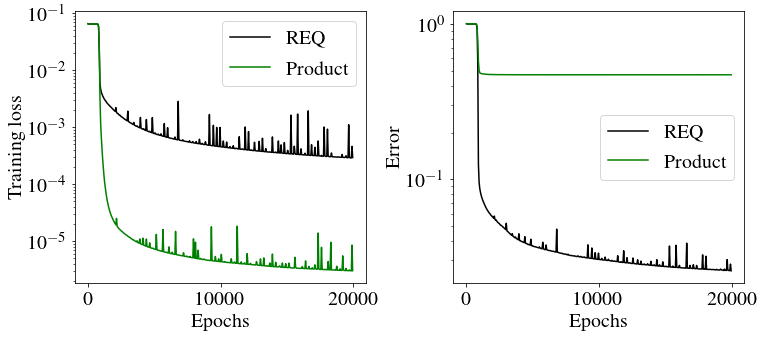

In [ ]:
#@title 4D heat conduction problem
k=1.

#Domain boundary
ax,bx = -1.,1.
ay,by = -1.,1.

numBatches = 1
num_epochs = 20000

numInt = 5000

#interior
inputw = numpy.random.uniform(ax+.01, bx-.01,numInt)
inputx = numpy.random.uniform(ax+.01, bx-.01,numInt)
inputy = numpy.random.uniform(ay+.01, by-.01,numInt)
inputz = numpy.random.uniform(ay+.01, by-.01,numInt)
inputw = datareshapeMLP(inputw,numBatches)
inputx = datareshapeMLP(inputx,numBatches)
inputy = datareshapeMLP(inputy,numBatches)
inputz = datareshapeMLP(inputz,numBatches)

#error calc
wi = numpy.random.uniform(ax, bx,5000)
xi = numpy.random.uniform(ax, bx,5000)
yi = numpy.random.uniform(ay, by,5000)
zi = numpy.random.uniform(ay, by,5000)


#NN
layer_sizes = [4, 100, 100, 1]

def f(w,x,y,z):
  return np.sin(k*np.pi*w)*np.sin(k*np.pi*x)*np.sin(k*np.pi*y)*np.sin(k*np.pi*z)

f_vect = vmap(f, (0, 0, 0, 0))

def exact(w,x,y,z):
  return (1/4.)*np.sin(k*np.pi*w)*np.sin(k*np.pi*x)*np.sin(k*np.pi*y)*np.sin(k*np.pi*z)/(k**2*np.pi**2)

e_vect = vmap(exact, (0, 0, 0, 0))



###################################
#Dirichlet R equiv

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uR(params, w, x, y, z):
    return phi(w,x,y,z)*NN(params,w,x,y,z)

def lossR(params, w, x, y, z):
    eq = d2udw2_vect(params, w, x, y, z) + d2udx2_vect(params, w, x, y, z) +d2udy2_vect(params, w, x, y, z) + d2udz2_vect(params, w, x, y, z) + f_vect(w,x,y,z)
    return np.mean(eq**2)

grad1 = grad(grad(uR,1),1)
grad2 = grad(grad(uR,2),2)
grad3 = grad(grad(uR,3),3)
grad4 = grad(grad(uR,4),4)
d2udw2_vect = vmap(grad1, (None, 0, 0, 0, 0))
d2udx2_vect = vmap(grad2, (None, 0, 0, 0, 0))
d2udy2_vect = vmap(grad3, (None, 0, 0, 0, 0))
d2udz2_vect = vmap(grad4, (None, 0, 0, 0, 0))
u_vect = vmap(uR, (None, 0, 0, 0, 0))


def run_trainingR(num_epochs, opt_state, w1, x1, y1, z1, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        w=w1[batch,:]
        x=x1[batch,:]
        y=y1[batch,:]
        z=z1[batch,:]
        params, opt_state, loss, Er = updateR(params, w, x, y, z, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))
        print('epoch: %3d error: %.6f' % (epoch, Er))

    return train_loss, opt_state, E

@jit
def updateR(params, w, x, y, z, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossR)(params, w, x, y, z)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, wi, xi, yi, zi)
    return get_params(opt_state), opt_state, value, Er

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingR(num_epochs, opt_state, inputw, inputx, inputy, inputz, numBatches)

params = get_params(opt_state)

errorR = e
lossR = train_loss




###################################
#Dirichlet

# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

def uN(params, w, x, y, z):
    return phiN(w,x,y,z)*NN(params,w,x,y,z)

grad1 = grad(grad(uN,1),1)
grad2 = grad(grad(uN,2),2)
grad3 = grad(grad(uN,3),3)
grad4 = grad(grad(uN,4),4)
d2udw2_vect = vmap(grad1, (None, 0, 0, 0, 0))
d2udx2_vect = vmap(grad2, (None, 0, 0, 0, 0))
d2udy2_vect = vmap(grad3, (None, 0, 0, 0, 0))
d2udz2_vect = vmap(grad4, (None, 0, 0, 0, 0))


def lossN(params, w, x, y, z):
    eq = d2udw2_vect(params, w, x, y, z) + d2udx2_vect(params, w, x, y, z) +d2udy2_vect(params, w, x, y, z) + d2udz2_vect(params, w, x, y, z) + f_vect(w,x,y,z)
    return np.mean(eq**2)


def run_trainingN(num_epochs, opt_state, w1, x1, y1, z1, numBatches=1):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    E = []
    train_loss = []
    train_loss_p = []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):

      for batch in range (numBatches):
        w=w1[batch,:]
        x=x1[batch,:]
        y=y1[batch,:]
        z=z1[batch,:]
        params, opt_state, loss, Er = updateN(params, w, x, y, z, opt_state)
        
      train_loss.append(loss)
      E.append(Er)

      if epoch % 1000 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss))
        print('epoch: %3d error: %.6f' % (epoch, Er))

    return train_loss, opt_state, E

@jit
def updateN(params, w, x, y, z, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(lossN)(params, w, x, y, z)
    opt_state = opt_update(0, grads, opt_state)
    Er = error(params, wi, xi, yi, zi)
    return get_params(opt_state), opt_state, value, Er


# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

train_loss, opt_state, e = run_trainingN(num_epochs, opt_state, inputw, inputx, inputy, inputz, numBatches)

params = get_params(opt_state)

errorN = e
lossN = train_loss





plt.rcParams.update({'font.size': 20})
######
#Plots
# fig = plt.figure(figsize=(24, 5))
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=.3)
# gs.update(hspace=.35)
# ax1 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
# ax3 = plt.subplot(gs[0, 1])
# ax4 = plt.subplot(gs[0, 2])

e_dx = 50

ax1.plot(range(num_epochs)[::e_dx],lossR[::e_dx], color="black", label='REQ')
ax1.plot(range(num_epochs)[::e_dx],lossN[::e_dx], color="green", label='Product')
# ax1.set_title('$k=1$')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training loss')
ax1.legend(loc='best')

ax2.plot(range(num_epochs)[::e_dx],errorR[::e_dx], color="black", label='REQ')
ax2.plot(range(num_epochs)[::e_dx],errorN[::e_dx], color="green", label='Product')
# ax2.set_title('$k=1$')
ax2.set_yscale('log')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend(loc='best')

# ax3.plot(range(num_epochs)[::e_dx],lossR2[::e_dx], color="black", label='$R-$equivalence')
# ax3.plot(range(num_epochs)[::e_dx],lossM2[::e_dx], color="green", label='MVP')
# ax3.plot(range(num_epochs)[::e_dx],lossNBC2[::e_dx], color="orange", label='Std. PINN')
# ax3.set_title('$k=2$')
# ax3.set_yscale('log')
# ax3.set_xlabel('Epochs')
# ax3.set_ylabel('Training loss')
# ax3.legend(loc='best')

# ax4.plot(range(num_epochs)[::e_dx],errorR2[::e_dx], color="black", label='$R-$equivalence')
# ax4.plot(range(num_epochs)[::e_dx],errorM2[::e_dx], color="green", label='MVC')
# ax4.plot(range(num_epochs)[::e_dx],errorNBC2[::e_dx], color="orange", label='Std. PINN')
# ax4.set_title('$k=2$')
# ax4.set_yscale('log')
# ax4.set_xlabel('Epochs')
# ax4.set_ylabel('Error')
# ax4.legend(loc='best')

plt.tight_layout()
fig.savefig('HeatEq4D.pdf', format='pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

